# KOH Posterior Analysis using Mici

This notebook looks at the different ways to implement an MCMC algorithm using Gaussian random-walk Metropolis proposal under the Mici framework.

The goal is to discover the best set-up and compare results against the MATLAB code previously implemented.

First, import the required packages and set up the KOH and Mici frameworks.

In [1]:
import matlabmodel as mm
from dataloader import DataLoader
from mappings import mapRto01, map01toR, mapRto0inf, map0inftoR, ell2rho, beta2ell
from jax import jit, grad

import numpy as np
import mici

import matplotlib.pyplot as plt

import arviz

plot_style = {
    'mathtext.fontset': 'cm',
    'font.family': 'serif',
    'axes.titlesize': 10,
    'axes.labelsize': 10,
    'xtick.labelsize': 6,
    'ytick.labelsize': 6,
    'legend.fontsize': 8,
    'legend.frameon': False,
    'axes.linewidth': 0.5,
    'lines.linewidth': 0.5,
    'axes.labelpad': 2.,
    'figure.dpi': 150,
}

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [2]:
seed = 1234
n_chain = 1
n_dim = 7
n_warm_up_iter = 4000
n_main_iter = 10000
rng = np.random.default_rng(seed)

init_states = np.array([[
    map01toR(0.4257), 
    map0inftoR(beta2ell(51.5551)), #these are the beta values!!!
    map0inftoR(beta2ell(3.5455)), 
    # map0inftoR(beta2ell(2)), 
    map0inftoR(0.25557), 
    map0inftoR(37.0552), 
    map0inftoR(10030.5142), 
    map0inftoR(79548.2126)
]])

tmax = 0.6
tmin = 0.2


##### KOH Model #####
dataloader = DataLoader()
data = dataloader.get_data() # loads normalised/standardised data
model = mm.MatlabModel(*data)
jitted_neg_log_posterior_density = jit(model.get_neg_log_dens_func())
grad_neg_log_posterior_density = jit(grad(model.get_neg_log_dens_func()))

##### Mici #####
system = mici.systems.EuclideanMetricSystem(
    neg_log_dens=jitted_neg_log_posterior_density,
    grad_neg_log_dens=grad_neg_log_posterior_density,
)
integrator = mici.integrators.LeapfrogIntegrator(system)

## Setup 1

Adapters:
- DualAveragingStepSizeAdapter(0.234)
- OnlineCovarianceMetricAdapter()

Results:
- Fails to achieve the target acceptance rate of 0.234, instead achieves around 0.2
- ESS bulk values are very similar for each variable.
- Parameter estimate for $\theta$ is very good. 
- 

In [3]:
##### Mici sampler and adapters #####
sampler = mici.samplers.StaticMetropolisHMC(system, integrator, rng, n_step=1)
adapters = [
    mici.adapters.DualAveragingStepSizeAdapter(0.234),
    mici.adapters.OnlineCovarianceMetricAdapter()
]

final_states, traces, stats = sampler.sample_chains(
    n_warm_up_iter, n_main_iter, init_states, adapters=adapters, n_process=n_chain
)

/Users/jamesbriant/miniforge3/envs/py311/lib/python3.11/site-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


Sampling stage: Initial fast adaptive [00:02] > Slow adaptive (1/7)

Chain 1/1: 100%|██████████|25/25 [00:00<00:00, 69.11it/s, accept_stat=0.209]

ValueError: output array is read-only

In [ ]:
for i in range(0, 1):
    print(np.mean(mapRto01(traces['pos'][0][:, i]))*(tmax-tmin) + tmin, '±', np.std(mapRto01(traces['pos'][0][:, i])*(tmax-tmin)))
for i in range(1, 3):
    print(np.mean(ell2rho(mapRto0inf(traces['pos'][0][:, i]))), '±', np.std(ell2rho(mapRto0inf(traces['pos'][0][:, i]))))
for i in range(3, 7):
    print(np.mean(mapRto0inf(traces['pos'][0][:, i])), '±', np.std(mapRto0inf(traces['pos'][0][:, i])))

0.42554149631683136 ± 0.014278702720900925
2.3444941911641833e-06 ± 2.029297183198658e-06
0.4284594613309433 ± 0.04081206920841679
0.26510890246638025 ± 0.05493173948815767
34.57040044854628 ± 9.650077834397903
8998.670345608803 ± 2973.0625336860226
78448.3715542844 ± 9274.704387609696


In [ ]:
arviz.summary(traces)#, var_names=["σ", "ϵ", "γ", "β", "x_0"])

Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pos[0],-0.258,0.146,-0.520,0.011,0.008,0.006,352.0,438.0,NaN
pos[1],-2.332,0.031,-2.383,-2.271,0.002,0.001,303.0,469.0,NaN
pos[2],-0.957,0.056,-1.064,-0.860,0.003,0.002,317.0,425.0,NaN
pos[3],-1.349,0.207,-1.714,-0.959,0.011,0.008,345.0,396.0,NaN
pos[4],3.504,0.283,2.977,4.024,0.016,0.011,319.0,477.0,NaN
pos[5],9.048,0.343,8.435,9.675,0.023,0.016,224.0,302.0,NaN
pos[6],11.263,0.117,11.031,11.472,0.007,0.005,313.0,534.0,NaN
hamiltonian,-786.158,2.653,-790.589,-781.153,0.118,0.084,476.0,1117.0,NaN


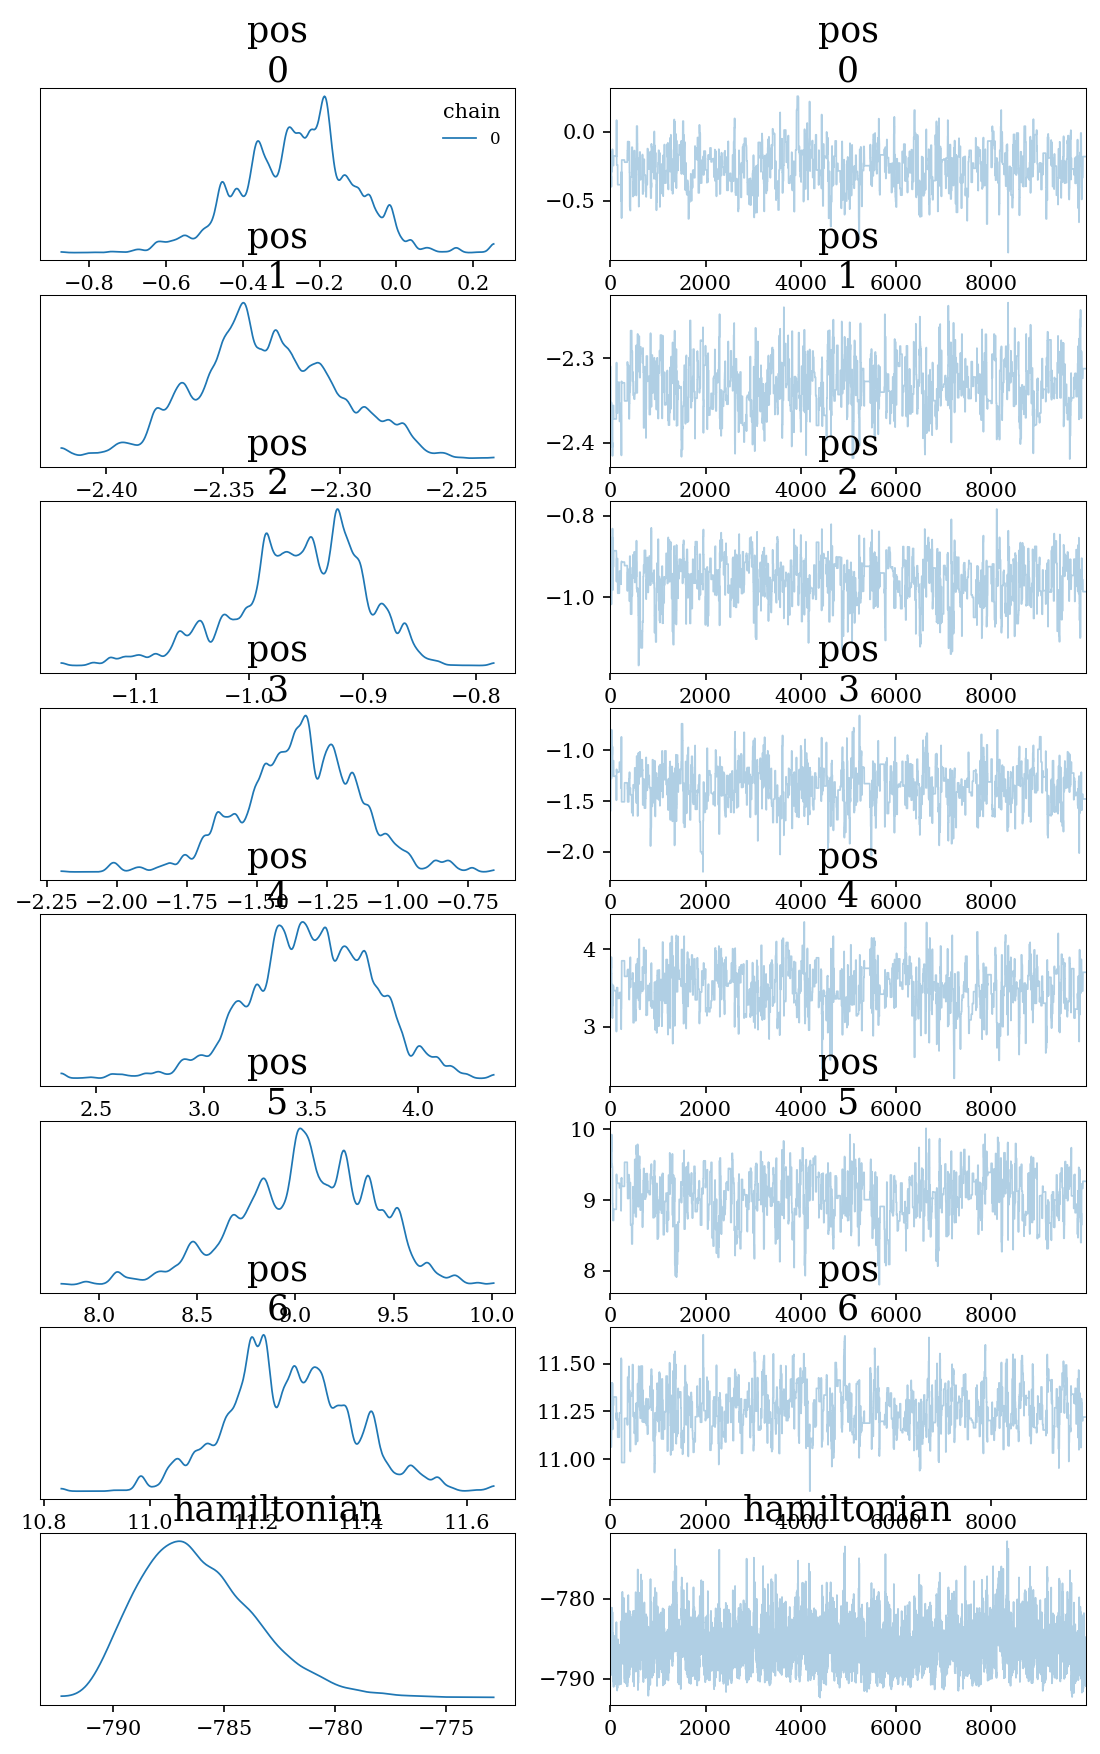

In [ ]:
with plt.style.context(plot_style):
    arviz.plot_trace(
        traces,
        # var_names=["σ", "ϵ", "γ", "β", "x_0"],
        figsize=(9, 2 * (7)),
        legend=True,
        compact=False,
    )
